In [1]:
import torch.nn as nn
import random
import torch
import numpy as np
import distance
import torch.nn.functional as F
import pandas as pd

from torch import optim
import time
import copy

In [2]:
from IPython.display import Audio, display
def allDone():
    urL = 'http://www.wavsource.com/snds_2018-06-03_5106726768923853/animals/cat_meow2.wav'
    display(Audio(url=urL, autoplay=True))
    
allDone()

In [3]:
# random.seed(80085)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def letterToIndex(letter):
    return amino_acids.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, len(amino_acids))
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, len(amino_acids))
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

amino_acids = 'XWGSAELQDMPFTRIHVNCY_K'

In [6]:
import numpy as np

## Final version: Train on "final fams" training set. Then, embedding entire "final fams training set" for kNN and silouette ... ??? Don't know what to do for silouette yet.

motifs_train = (np.genfromtxt('data_filtered/motifs_train.csv',dtype='U'))
motifxFamMatrix_train = np.genfromtxt('data_filtered/motifxFamMatrix_train.csv',delimiter=',',dtype=int)

motifs_test = (np.genfromtxt('data_filtered/motifs_test.csv',dtype='U'))
motifxFamMatrix_test = np.genfromtxt('data_filtered/motifxFamMatrix_test.csv',delimiter=',',dtype=int)

fams = (np.genfromtxt('data_filtered/fams.csv',dtype='U'))


In [5]:
def siamese_loss(z1, z2, label, margin=1.0):
    euclidean_distance = F.pairwise_distance(z1, z2) 
    loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))
    return loss_contrastive

In [6]:
def getBatch(idc):
    
    mIdx1_batch = []
    mIdx2_batch = []
    label_batch = []
    mIdc1 = []
    mIdc2 = []
    switch = 0
    
    while switch < BATCH_SIZE:
        mIdx1 = random.choice( idc )  #random.choice(trainIdc)
        motif1 = motifs_train[mIdx1]
        motif_tensor1 = lineToTensor(motif1)

        fIdx1 = np.where(motifxFamMatrix_train[mIdx1]==1)

        fam1 = fams[fIdx1]

        mIdx2 = random.choice( idc )  #random.choice(trainIdc)
        motif2 = motifs_train[mIdx2]
        motif_tensor2 = lineToTensor(motif2)

        fIdx2 = np.where(motifxFamMatrix_train[mIdx2]==1)
        fam2 = fams[fIdx2]
        
        if len(fam1)==0 and len(fam2)==0:
            continue
        
        label = distance.jaccard(set(fam1),set(fam2))
    
        if switch%2 != round(label):
            continue
            
        label = torch.tensor([label]).unsqueeze(0)
        
        mIdx1_batch.append(motif_tensor1)
        mIdx2_batch.append(motif_tensor2)
        label_batch.append(label)
        
        motif_idc1 = [letterToIndex(aa) for aa in motif1]
        motif_idc1 = torch.tensor(motif_idc1)
        mIdc1.append(mIdx1)
        
        motif_idc2 = [letterToIndex(aa) for aa in motif2]
        motif_idc2 = torch.tensor(motif_idc2)
        mIdc2.append(mIdx2)

        switch += 1

    mIdx1_batch = torch.nn.utils.rnn.pad_sequence(mIdx1_batch, batch_first=False).squeeze(2)
    mIdx2_batch = torch.nn.utils.rnn.pad_sequence(mIdx2_batch, batch_first=False).squeeze(2)

    maxLen2 = mIdx2_batch.shape[0]
    maxLen1 = mIdx1_batch.shape[0]
    
    label_batch = torch.stack(label_batch)
        
    return (mIdx1_batch, mIdx2_batch, maxLen1, maxLen2, label_batch,
           mIdc1, mIdc2)

In [7]:
def getSampForTesting(myMotifs,mIdx):
    
    motif = myMotifs[mIdx]
    motif_tensor = lineToTensor(motif)

    mIdx_batch = [motif_tensor]

    motif_idc = [letterToIndex(aa) for aa in motif]
    motif_idc = torch.tensor(motif_idc)

    mIdx_batch = torch.nn.utils.rnn.pad_sequence(mIdx_batch, batch_first=False).squeeze(2)

    maxLen = mIdx_batch.shape[0]
            
    return (mIdx_batch, maxLen)

In [8]:
# this is the most current model * * * * * * * * 

HIDDEN_DIM_0 = 250 # 50
HIDDEN_DIM_1 = HIDDEN_DIM_0 * 2
HIDDEN_DIM_PER_AA = 100 # 10

OUT_DIM = 15*HIDDEN_DIM_PER_AA

class SiameseNet(nn.Module):
        
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.lstm = nn.LSTM(len(amino_acids), HIDDEN_DIM_0, num_layers=2, bidirectional=True)
        self.h1 = nn.Sequential(nn.Linear(HIDDEN_DIM_0*2, HIDDEN_DIM_1),
#                                  nn.BatchNorm1d(HIDDEN_DIM_1),
                                 nn.ReLU()) 
        self.h_out = nn.Linear(HIDDEN_DIM_1, HIDDEN_DIM_PER_AA)
    
    def forward_once(self, BATCH_SIZE, sentence):  
        lstm_out, (h,c) = self.lstm( sentence )
        h1 = self.h1( lstm_out )
        h_out = self.h_out( h1 )
        h_out = h_out.reshape(BATCH_SIZE,OUT_DIM)
        return h_out
        
    def forward(self, input1, input2, BATCH_SIZE):
        embed = self.forward_once(BATCH_SIZE, input1)
        embed2 = self.forward_once(BATCH_SIZE, input2)
        return (embed, embed2)

In [9]:
print(HIDDEN_DIM_0, HIDDEN_DIM_1, OUT_DIM)

250 500 1500


## Train your own network ...

In [10]:
import time

start = time.time()

model = SiameseNet() 
model = model.to(device)
best_model_wts = copy.deepcopy(model.state_dict())

name_guess_samples = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.005 )

loss_history = []
best_loss = 1000

BATCH_SIZE = 32
iters = 10000

start_trainTime = time.time()

for bIdx in range(iters): # previously, never did less than 2500 iters
    optimizer.zero_grad()
    idcForTraining = [i for i in range(len(motifs_train))]

    (mIdx1_batch, mIdx2_batch, maxLen1, maxLen2, label_batch,
       mIdc1, mIdc2) = getBatch(idcForTraining)

    mIdx1_batch = mIdx1_batch.to(device)
    mIdx2_batch = mIdx2_batch.to(device)
    label_batch = label_batch.to(device)
    embed, embed_2 = model(mIdx1_batch, mIdx2_batch, BATCH_SIZE)        
    loss = siamese_loss(embed, embed_2, label_batch, margin=2.0)
    loss.backward()
    optimizer.step()   
    loss_history.append(loss)

    best_model_wts = copy.deepcopy(model.state_dict())
    final_model = SiameseNet().to(device)
    final_model.load_state_dict(best_model_wts)
        
    if bIdx%10==0:
        print("Time: %5.3f secs, Iter %d\n* Current loss %5.7f" % ( time.time()-start, bIdx+1, loss ))
        start = time.time()

print("Total train time: %5.3f minutes" % ((time.time()-start_trainTime)/60.0))

torch.save(final_model.state_dict(), 
           "file_name")

## Save your new embedding produced by the network...

In [56]:
idcForEmbedding = [x for x in range(len(motifs_test))]

In [57]:
motifs_all = np.hstack((motifs_train,motifs_test))
motifs_all.shape

motifxFamMatrix_all = np.vstack((motifxFamMatrix_train,motifxFamMatrix_test))
motifxFamMatrix_all.shape

(7535, 8)

In [58]:
def saveEmbedding(myMotifs,whichMotifs):
    embeds = []
    BATCH_SIZE = 1

    final_model.eval()

    for idx in range(len(myMotifs)):
        (mIdx_batch, maxLen) = getSampForTesting(myMotifs,idx)
        mIdx_batch = mIdx_batch.to(device)
        embed = final_model.forward_once(BATCH_SIZE,mIdx_batch)
        embed = embed.squeeze()
        embeds.append(embed.cpu().detach().numpy())

    df = pd.DataFrame(embeds,dtype=float)
    df.to_csv("siameseResults/%s_embedding_%s.csv" % (run, whichMotifs),header=None,index=None)
    
    return embeds

In [59]:
myEmbeds = saveEmbedding(motifs_all,'motifs_all')
_ = saveEmbedding(motifs_test,'motifs_test')
_ = saveEmbedding(motifs_train,'motifs_train')

In [60]:
import umap.umap_ as umap
umapper = umap.UMAP(
    n_neighbors=200,
    min_dist=0.1,
    n_components=2,
    metric='euclidean' )

s = time.time()
pos_umap = umapper.fit_transform(myEmbeds)
allDone()

print ("secs: %5.3f" % (time.time()-s))

/usr/local/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../usr/local/anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


secs: 51.781


In [61]:
import os
f = 'siameseResults/%s_FIGS/' % run
os.mkdir(f)

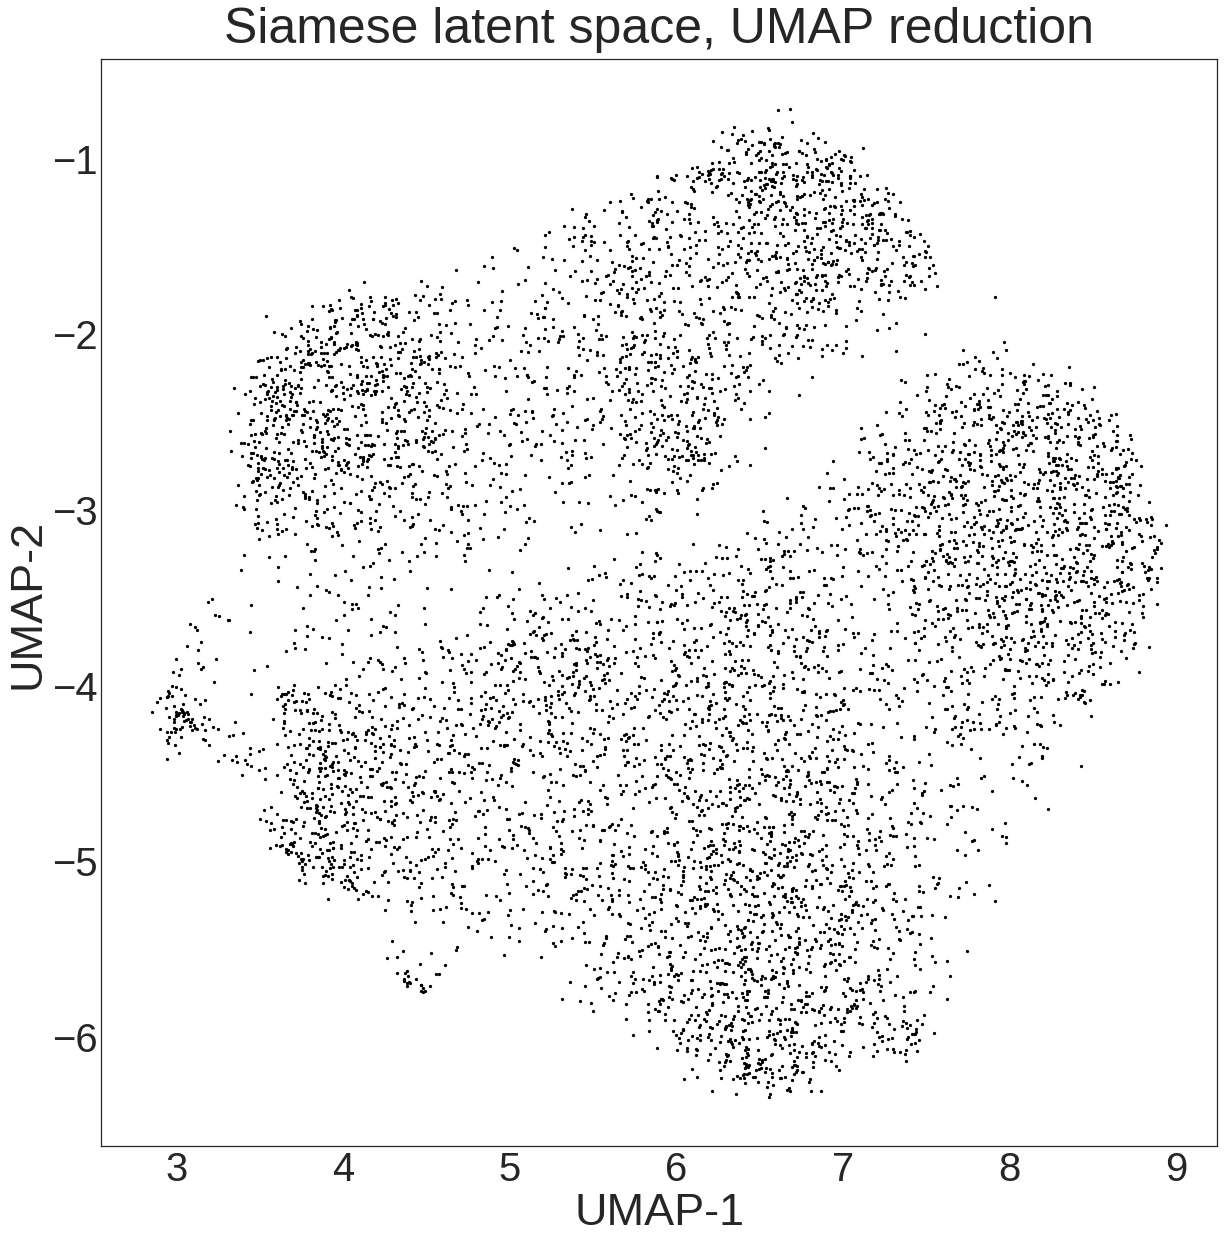

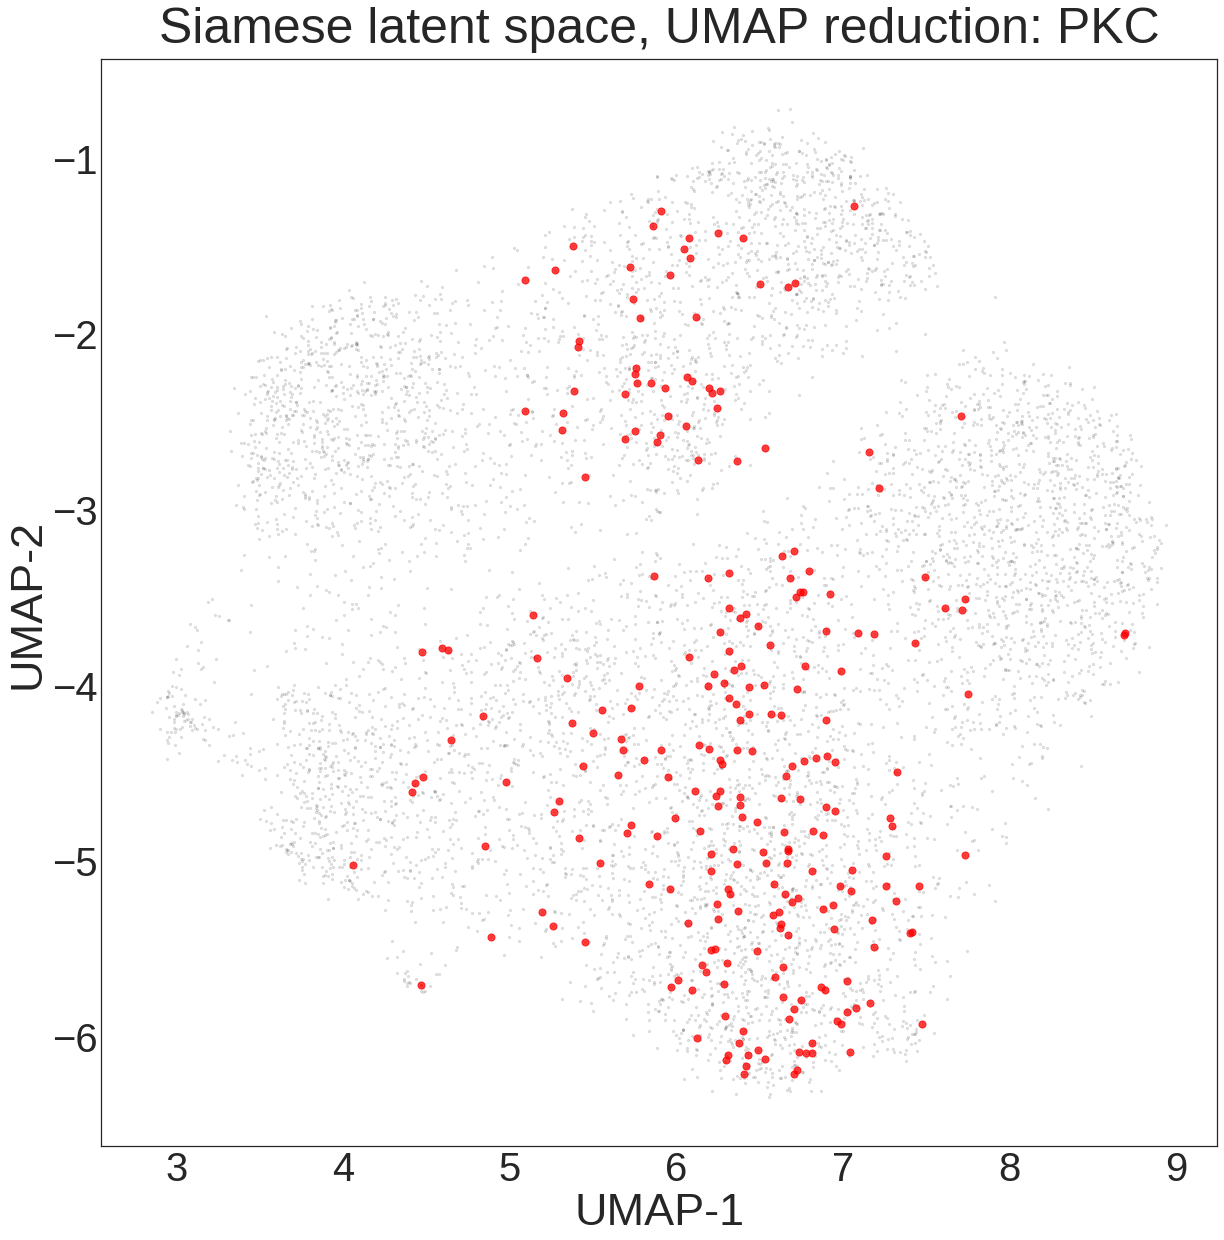

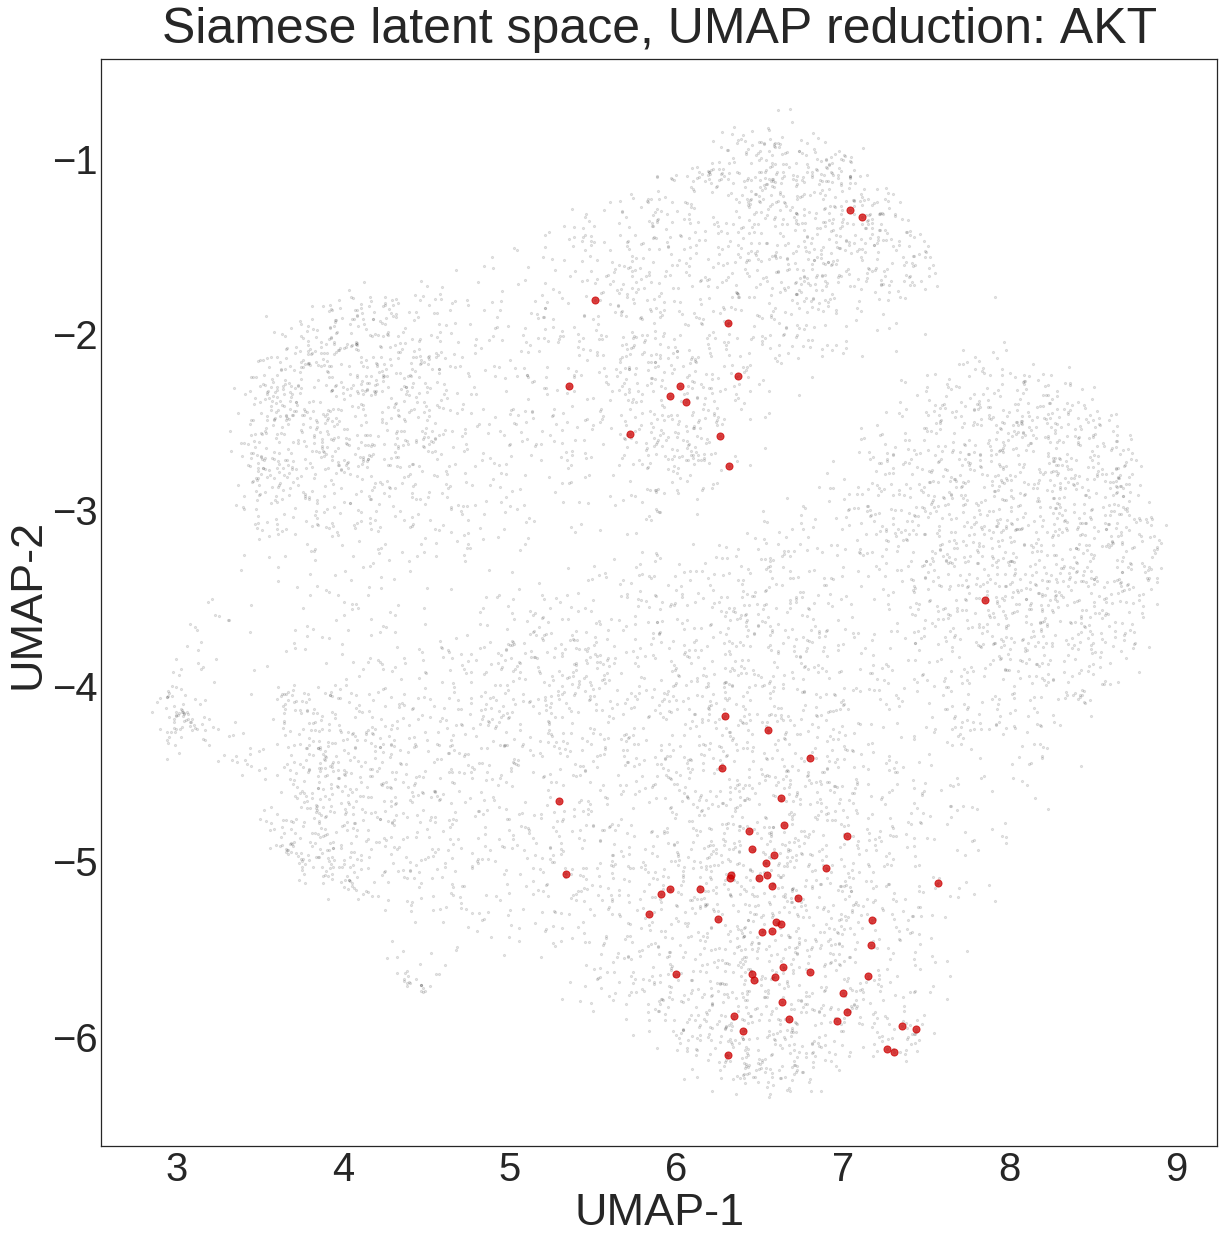

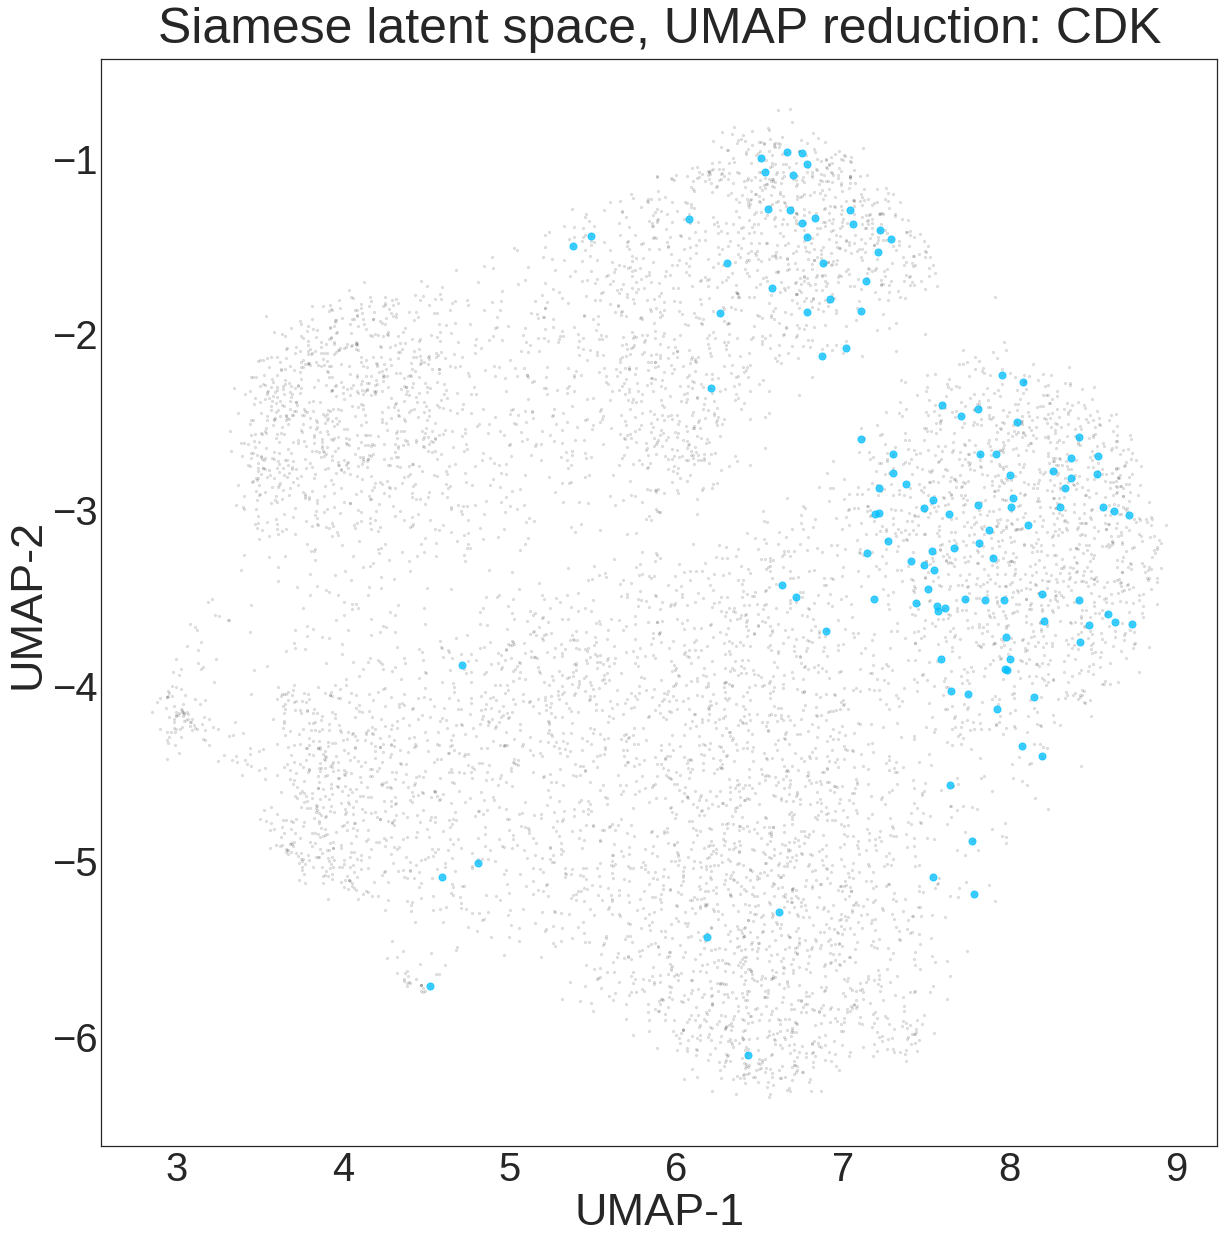

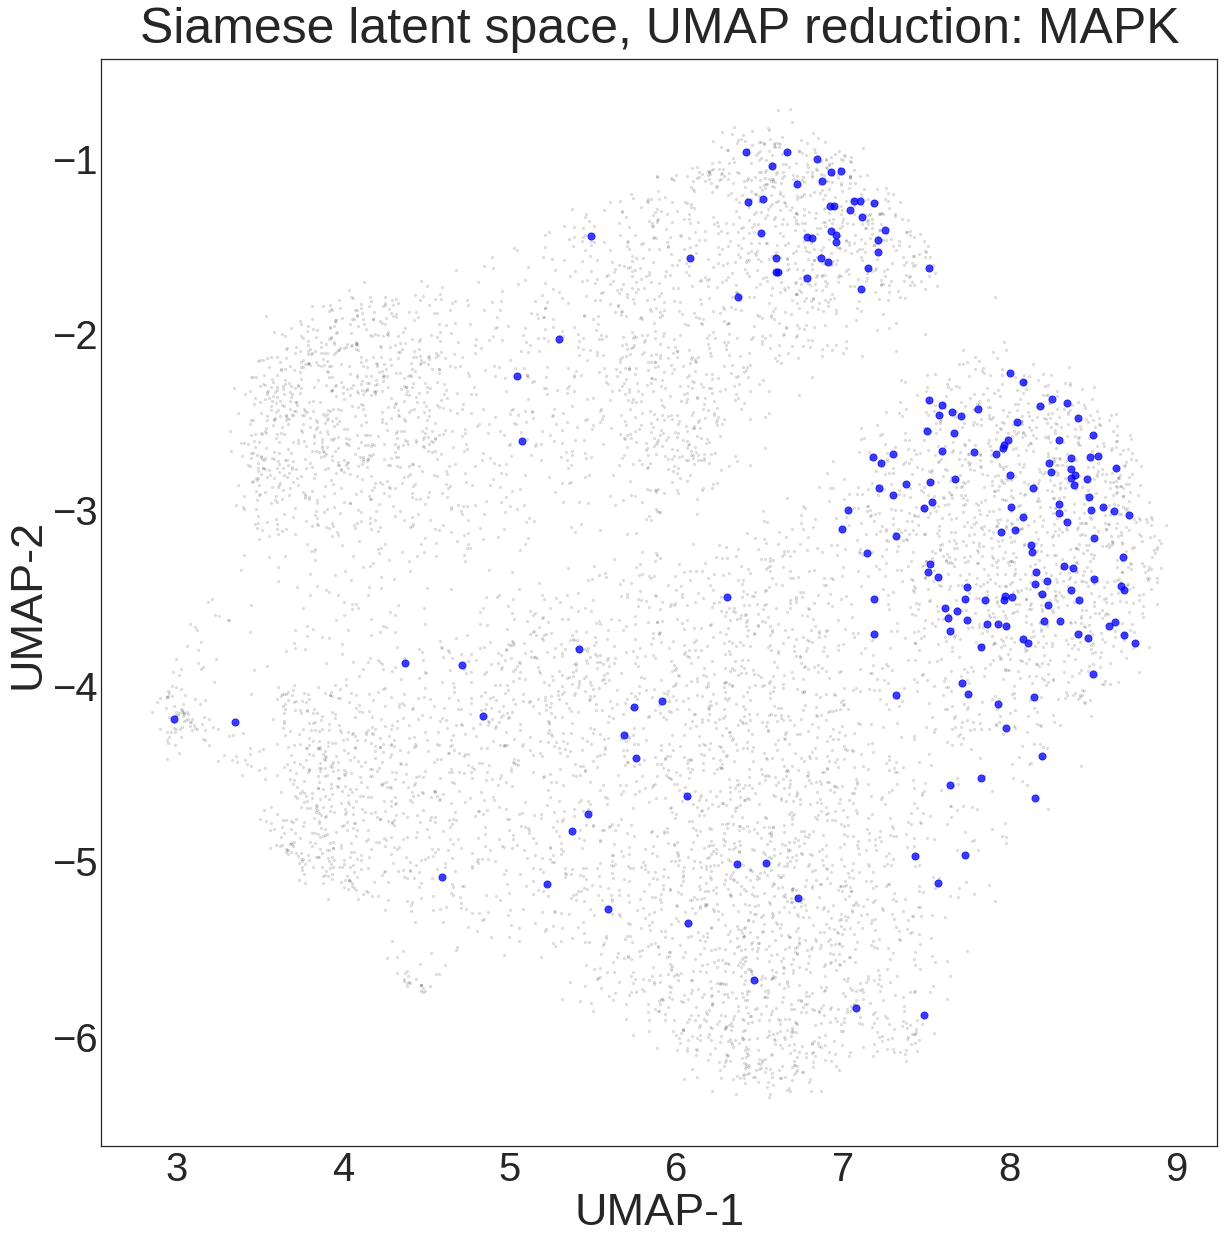

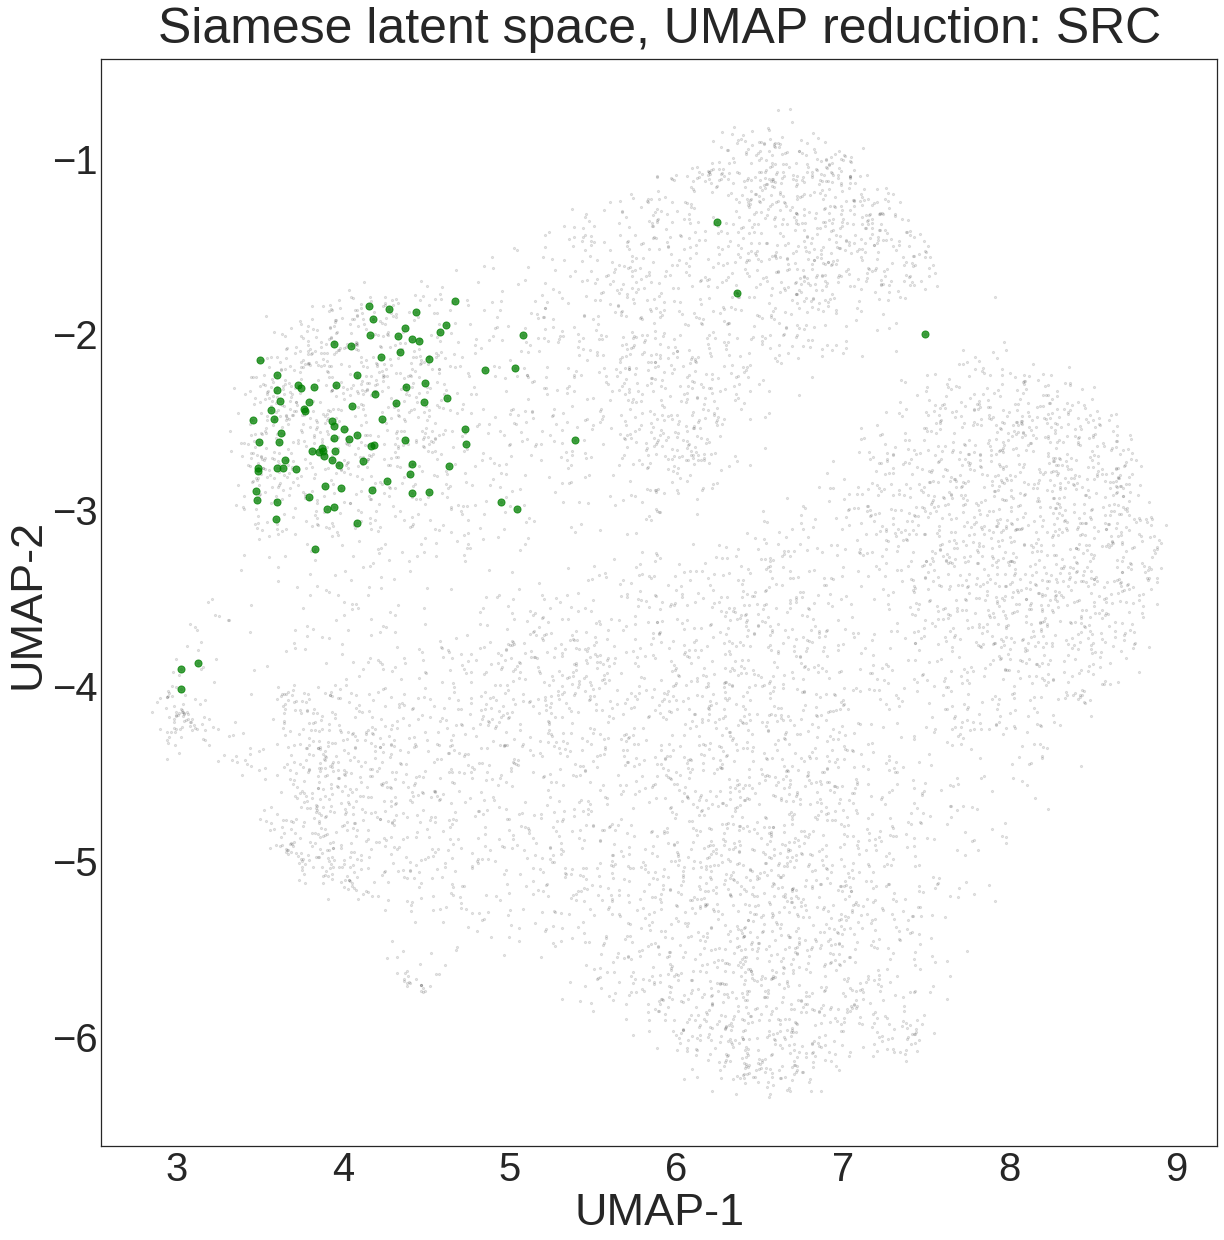

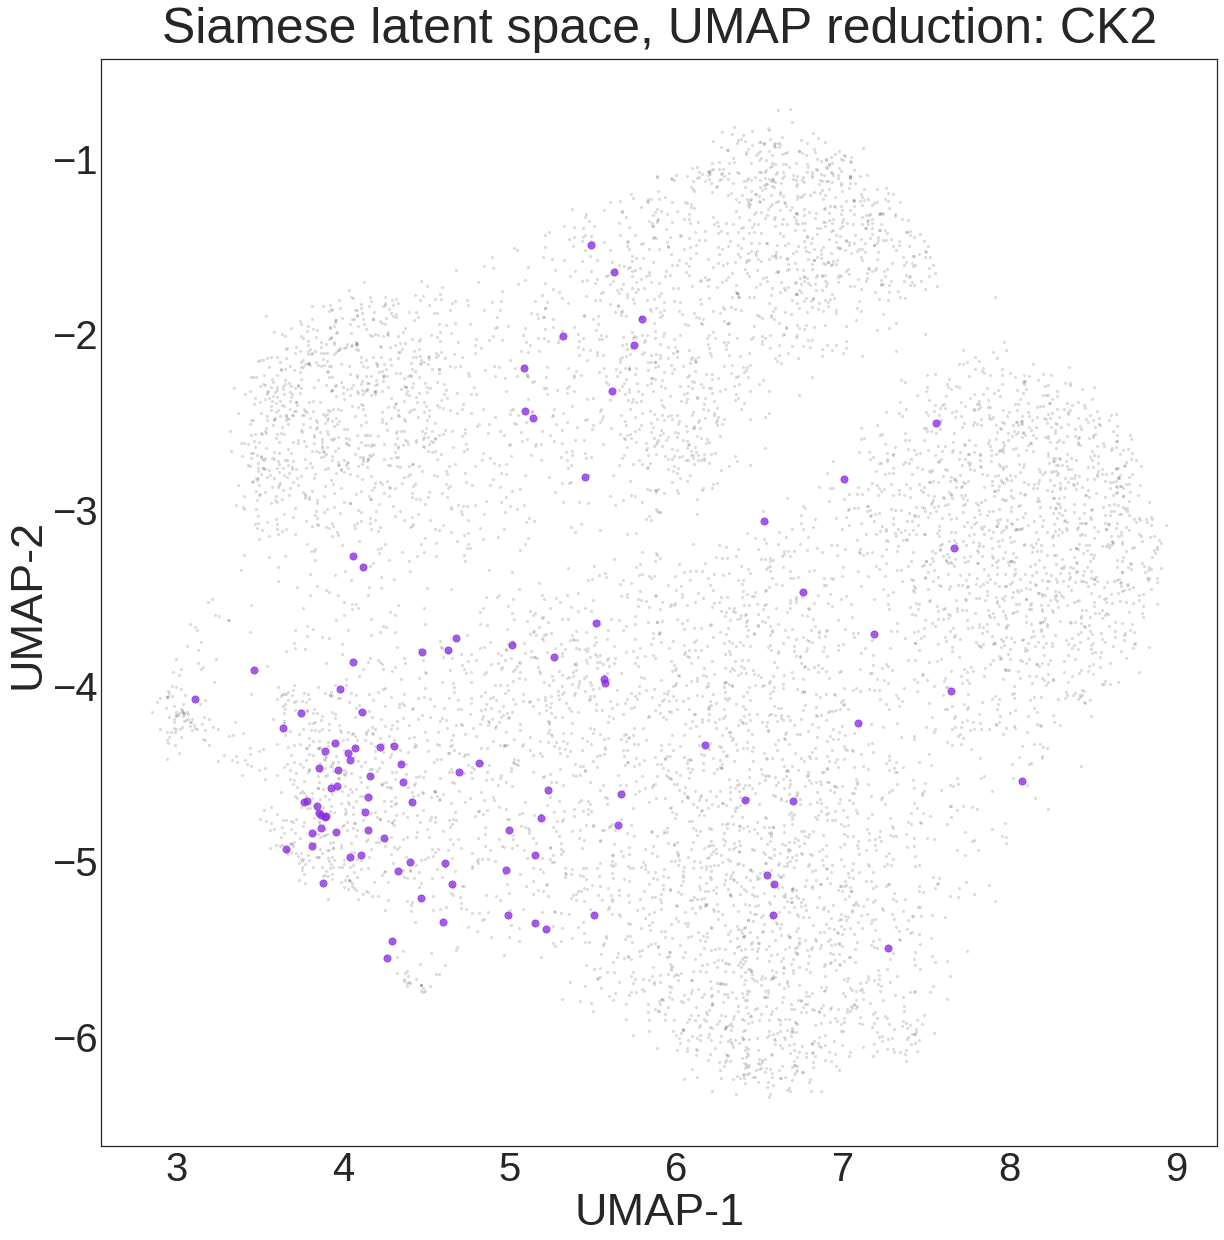

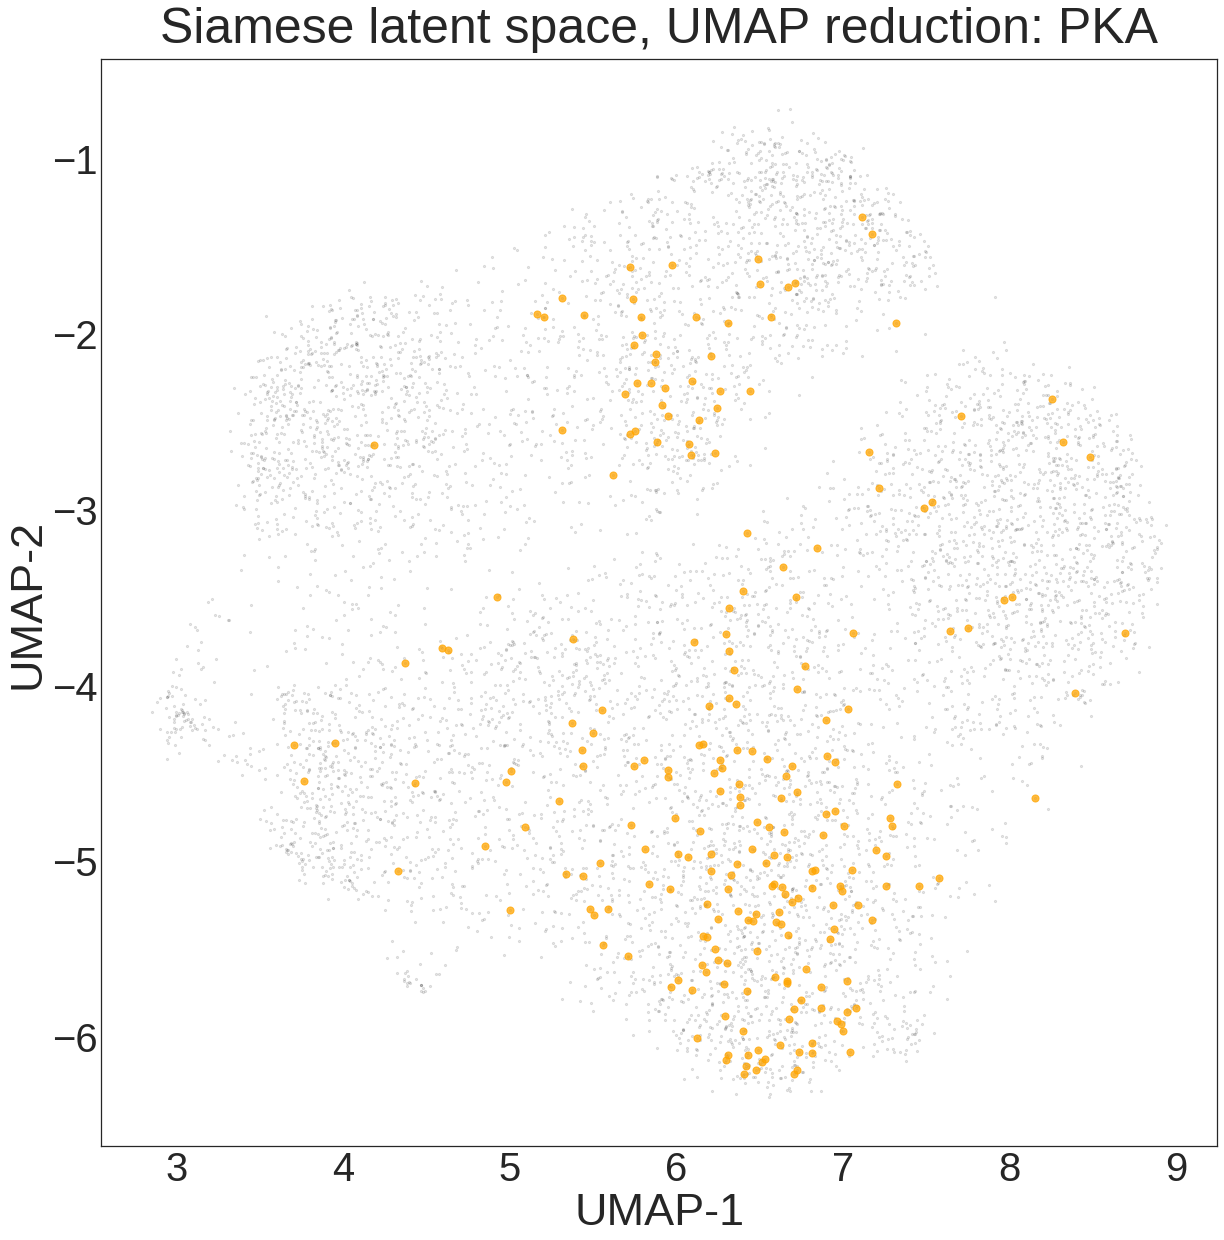

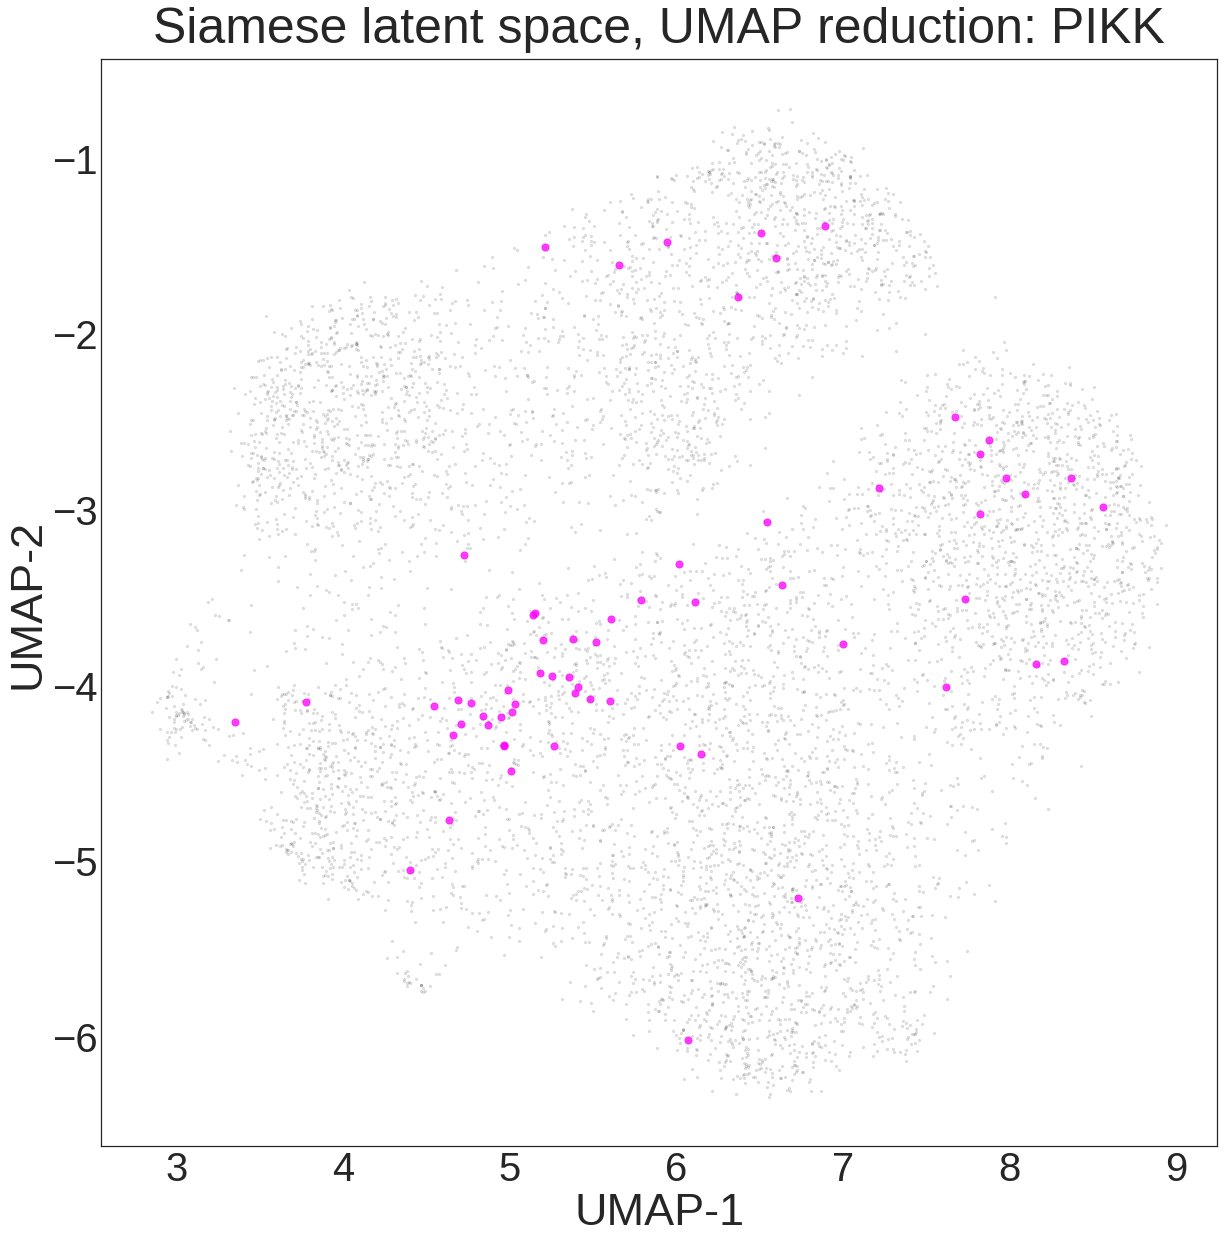

In [62]:
label_size = 45
title_size = 50
tick_size = 40

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

colors = ['red','#CD0000','deepskyblue','blue','green','blueviolet','orange','magenta','blueviolet','violet','deeppink','crimson','mediumslateblue','brown']

plt.figure(figsize=(20,20))
plt.scatter(pos_umap[:, 0], pos_umap[:, 1], marker = 'o',s=5,color='black', alpha=1) #alpha=0.25)
plt.title("Siamese latent space, UMAP reduction",fontsize=title_size,y=1.01)
plt.xlabel("UMAP-1",fontsize=label_size)
plt.ylabel("UMAP-2",fontsize=label_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.savefig( f + "noHighlights")
plt.show()

pop_fams = ['PKC', 'AKT', 'CDK', 'MAPK', 'SRC', 'CK2', 'PKA', 'PIKK']

i = -1
for _,fam in enumerate(pop_fams):
    
    i+=1
    fIdx = np.where(fams==fam)[0][0]
    plt.figure(figsize=(20,20))
    plt.title(("Siamese latent space, UMAP reduction: %s" % fam),fontsize=title_size,y=1.01)
    plt.xticks(fontsize=tick_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
    plt.yticks(fontsize=tick_size)
    plt.xlabel("UMAP-1",fontsize=label_size)
    plt.ylabel("UMAP-2",fontsize=label_size)
    plt.scatter(pos_umap[:, 0], pos_umap[:, 1], marker = 'o',s=5,color='black',alpha=0.10)
    for mIdx, (x, y) in enumerate(zip(pos_umap[:, 0], pos_umap[:, 1])):
        if motifs_all[mIdx] not in motifs_test:
            continue
        elif motifxFamMatrix_all[mIdx][fIdx]==1:
            plt.scatter(x,y,marker='o',s=50,c=colors[i],alpha=0.75)          
    plt.savefig((f+"%s" % fam))
    plt.show()